In [27]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
import gc
import sklearn.metrics
import timeit
from scipy.interpolate import CubicSpline
gc.collect()


34483

In [28]:
img =cv2.imread('BMS-tile DAPI annotated eroded.tif') #segmented and eroded image
img_gene1=cv2.imread('BMS-tile_gene1.tif') #image of CDX2 gene expression
img_gene2=cv2.imread('BMS-tile_gene2.tif') #image of SOX1 gene expression

In [42]:
def get_intersection(hey,initial_pos,epsilon,contour): #function that finds the intersection points and also returns sides of region(normal line)
    x_vec=hey[:,0]
    y_vec=hey[:,1]
    fit=np.polyfit(x=x_vec[initial_pos-epsilon:initial_pos+epsilon], y=y_vec[initial_pos-epsilon:initial_pos+epsilon], deg=1)
    m_normal=-1/fit[0]
    b_normal=y_vec[initial_pos]-(m_normal*x_vec[initial_pos])
        
    if abs(m_normal)>1000:
        y_list=np.linspace(y_vec[initial_pos]-100,y_vec[initial_pos]+100,100000)
        x_list=np.repeat(x_vec[initial_pos], np.shape(y_list)[0])
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    else:
        x_list=np.linspace(x_vec[initial_pos]-100,x_vec[initial_pos]+100,100000)
        y_list=m_normal*x_list+b_normal
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    coord_list=list(zip(y_list, x_list))
    arr2_2=np.array(coord_list)
    arr1=np.squeeze(contour)
    for hh in range(np.shape(arr2_2)[0]-1):
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        
    intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    if np.shape(intersection)[0]<2:
        arr1=np.concatenate((arr1,arr1+1),axis=0)
        intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    if np.shape(intersection)[0]>2: #fix this make more general
        dist_1=sklearn.metrics.pairwise_distances(intersection)
        np.fill_diagonal(dist_1, 100)
        dist_1=np.tril(dist_1, k=0)
        dist_1[dist_1==0]=100
        a=np.where(dist_1<5)
        mid_point=np.delete(intersection, a[0][:],0)
        intersection=mid_point
        if np.shape(mid_point)[0]>2:
            repe=np.repeat([[y_vec[initial_pos],x_vec[initial_pos]]],np.shape(mid_point)[0], axis=0)
            dist=np.sqrt((mid_point[:,0]-repe[:,0])**2+(mid_point[:,1]-repe[:,1])**2)
            mins=np.partition(dist,2)[0:2]
            min_id1=np.where(dist==mins[0])
            min_id2=np.where(dist==mins[1])
            intersection=mid_point[[min_id1[0][0],min_id2[0][0]],:]
        
    id1=np.where((arr2_2[:,1]==intersection[0,1]) & (arr2_2[:,0]==intersection[0,0]))
    id2=np.where((arr2_2[:,1]==intersection[1,1]) & (arr2_2[:,0]==intersection[1,0]))
    id_min=np.min([id1[0][0],id2[0][0]])
    id_max=np.max([id1[0][0],id2[0][0]])
    side=coord_list[id_min:id_max]
    
    edge1=np.where((arr1[:,1]==intersection[0,1]) & (arr1[:,0]==intersection[0,0]))
    edge2=np.where((arr1[:,1]==intersection[1,1]) & (arr1[:,0]==intersection[1,0]))
    
    return side, edge1, edge2, arr1

In [87]:
def get_gene_dipole(hey,contour,epsilon,img_gene1,img_gene2): #function that separates organoids into sections and returns gene dipole
    jj=0
    
    #n_segments=20 #number of segments
    #epsilon=np.shape(hey)[0]//n_segments
    
    epsilon=epsilon
    n_segments=np.shape(hey)[0]//epsilon
    initial_pos=epsilon
    gene1=np.empty([1,0])
    gene2=np.empty([1,0])
    position=np.empty([1,0])
    
    # if organoid only has two section aka small skeleton
    if initial_pos+epsilon>(np.shape(hey)[0]):
        mid_point=np.shape(hey)[0]//2
        eps=mid_point-1
        side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
        edges=np.sort([edge1[0][0],edge2[0][0]])
        #first half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=arr1[edges[0]:edges[1]]
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'bo')
        
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point-eps/2)
        
         
    
        # second half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        
        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'ro')
        #plt.show()
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point+eps/2)
       
         
        if np.shape(gene1)[0]==1:
            area_red=gene1[0]
            area_blue=gene2[0]
        else:
            area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
            area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        
        dipole=area_red/(area_red+area_blue)
    
    
    #long skeleton organoid
    n=0
    while (initial_pos+epsilon)<(np.shape(hey)[0]): #iterate through every point on skeleton to get normal lines
        #first section (fix path,sometimes wrong, take shortest path?)
        if n==0:
            mid_point=initial_pos
            eps=epsilon
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            #line1=arr1[edges[0]:edges[1]]
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path1)[0]>np.shape(path2)[0]:
                line1=path2
            else:
                line1=path1
            
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
            #plt.plot(region[:,0],region[:,1],'go')
            
            segment=np.squeeze(img_gene1[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)  
            
        
        n=n+1
        side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
        #edge_min_1=np.min([edge1,edge2])
        #edge_max_2=np.max([edge1,edge2])
    
        
        
        
        initial_pos=initial_pos+epsilon
        
        
        side2, edge3, edge4, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
        #edge_min_3=np.min([edge3,edge4])
        #edge_max_4=np.max([edge3,edge4])
        edges=np.sort([edge1[0][0],edge2[0][0],edge3[0][0],edge4[0][0]])
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        if edges[2]==edges[3]:
            edges[3]=edges[3]+1
        line1=arr1[edges[0]:edges[1]]
        line2=arr1[edges[2]:edges[3]]
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        if np.sum(line2[0,:]-line2[-1,:]) >0:
            line2=np.flip(line2,0)
        side2=np.flip(side2,0)
        region_cont=np.concatenate((line1,side1,line2,side2))
        side_cross=np.array([x for x in set(tuple(x) for x in side1) & set(tuple(x) for x in side2)])
        if np.shape(side_cross)[0]>0:
            line1=np.flip(line1,0)
            line2=np.flip(line2,0)
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, initial_pos-epsilon/2)
        initial_pos=initial_pos
        #last section
        if n==n_segments-1:
            mid_point=initial_pos-epsilon//4
            eps=epsilon//4
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path2)[0]>np.shape(path1)[0]:
                line1=path1
            else:
                line1=path2
    
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
           # plt.plot(region[:,0],region[:,1],'ro')
            #plt.show()
            segment=np.squeeze(img_gene1[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)
             
    
    #gene_1_mean=np.mean(np.squeeze(img_gene1[:,:,0]))/np.max(gene1)
    #gene_2_mean=np.mean(np.squeeze(img_gene2[:,:,0]))/np.max(gene2)
    
   # print(dip_1)
    #print(dip_2)
    if np.shape(gene1)[0]==1:
        dip_1=0
        dip_2=0    
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
    else:
        area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
        area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        dip_1=gene1/np.max(gene1)*(position-np.shape(hey)[0]/2)
        dip_2=gene2/np.max(gene2)*(position-np.shape(hey)[0]/2)    
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)#area_red/(area_red+area_blue)#np.abs(gene_1_mean*r_1-gene_2_mean*r_2)/np.abs(r_1-r_2)#
    #yp=np.linspace(0, 1, 1000)
    #plt.plot(position, gene1/np.max(gene1),'r.')
    #plt.plot(position, gene2/np.max(gene2),'b.')
    #plt.plot(yp,fit_1(yp),'r--')
    #plt.plot(yp,fit_2(yp),'b--')
    #plt.axis([0, position[-1]+50, 0, 1])
    #plt.show()
    if dipole.size == 0:
        dipole=0
    return dipole

In [88]:
# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
start = timeit.timeit()
dipole_list=np.empty([1,0])
elongation_list=np.empty([1,0])
aspect_ratio_list=np.empty([1,0])
centroid_list=[[1,1], [1,1]]
true_org=np.empty([1,0])

for ii in range(np.shape(contours)[0]):
    
    M = cv2.moments(contours[ii])
    if M["m00"] == 0:
        true_org=np.append(true_org,0)
    else:
        true_org=np.append(true_org,1)


for ii in range(np.shape(contours)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))

        obj = np.argwhere(filled_array == 255)

        

        bin_arr = np.where(filled_array > 0, 1, 0)
    
        image = bin_arr

    # perform skeletonization
    
        skeleton1 = skeletonize(image)


        binSkel = skeleton1*1
        skelObj = np.argwhere(binSkel == 1)

        fil = FilFinder2D(binSkel, distance=250 * u.pc, mask=skeleton1)
        fil.preprocess_image(flatten_percent=85)
        fil.create_mask(border_masking=True, verbose=False,
        use_existing_mask=True)
        fil.medskel(verbose=False)
        fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')
        skeleton_length=fil.lengths()
        #plt.plot(obj[:,0],obj[:,1], 'bo')
        #plt.plot(skelObj[:,0],skelObj[:,1], 'ko')


        x,y,w,h = cv2.boundingRect(contours[ii])
        aspect_ratio = float(w)/h
        M = cv2.moments(contours[ii])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid=np.array([cY,cX])
        hey_1 = np.argwhere(fil.skeleton_longpath==1)
        if hey_1.size==0:
            hey_1=skelObj
        im_zer = np.zeros( (img.shape[0],img.shape[1]) )
        skele_im=im_zer
        skele_im[hey_1[:,0],hey_1[:,1]]=255
        n=0
        ma=np.array([1,1,1])
        ok2=0
        while ok2==0:
            
            in_x=hey_1[n,0]
            in_y=hey_1[n,1]
            ma=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
            n=n+1
            if np.sum(ma)<255*3:
                ok2=1
        skeleton=np.array([[0,1],[in_x, in_y]])
        ok=0
        x_prev=1
        y_prev=1
        neighbors=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
        center_y=in_y
        center_x=in_x
        n=0
        while ok==0:
        
        
            neighbors[x_prev,y_prev]=0
            neighbors[1,1]=0
            res=np.where(neighbors==255)
            if res[0].size==0 :
         
                break
        
            y_next=res[1]
            x_next=res[0]
            skeleton=np.append(skeleton, [[x_next[0]-1+center_x, y_next[0]-1+center_y]], axis=0)
            y_prev=2-y_next[0]
            x_prev=2-x_next[0]
        
            center_y=center_y+y_next[0]-1
            center_x=center_x+x_next[0]-1
        
            neighbors=skele_im[-1+center_x:2+center_x,-1+center_y:2+center_y]
        

        skeleton=np.delete(skeleton, 0,0)
        hey=skeleton
        epsilon=20
        if np.shape(hey)[0]<6:
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
        elongation=np.shape(hey)[0]
        dipole=get_gene_dipole(hey,contours[ii],epsilon,img_gene1,img_gene2)
        dipole_list=np.append(dipole_list,dipole)
        elongation_list=np.append(elongation_list,elongation)
        aspect_ratio_list=np.append(aspect_ratio_list,aspect_ratio)
        centroid_list=np.append(centroid_list,[centroid],axis=0)
        print('dipole gene=',dipole)
        print('elongation=',elongation)
        print('aspect ratio=',aspect_ratio)
        print('centroid=',centroid)
centroid_list=np.delete(centroid_list, [0,1],0)
end = timeit.timeit()
print(end - start)

C:\Users\heito\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


dipole gene= 0.11886289621929128
elongation= 137
aspect ratio= 0.6376811594202898
centroid= [5985 1971]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.025393700124519
elongation= 222
aspect ratio= 0.36917562724014336
centroid= [5790 1609]
dipole gene= 3.039070558003641
elongation= 300
aspect ratio= 0.4098360655737705
centroid= [5821 1886]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.822026940846741
elongation= 298
aspect ratio= 0.34472934472934474
centroid= [5769 2206]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.1939925274016545
elongation= 263
aspect ratio= 0.4290322580645161
centroid= [5747 3140]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.32654929635648
elongation= 235
aspect ratio= 0.5119453924914675
centroid= [5724 2616]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.6986921010643825
elongation= 227
aspect ratio= 0.5359712230215827
centroid= [5723 3424]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.811485583654031
elongation= 249
aspect ratio= 0.5117845117845118
centroid= [5716 2908]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 5.611944744919745
elongation= 343
aspect ratio= 0.610738255033557
centroid= [5729 3725]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 6.339270500176332
elongation= 364
aspect ratio= 0.5548780487804879
centroid= [5718 4781]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.485628446979802
elongation= 272
aspect ratio= 0.6245847176079734
centroid= [5675 4461]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.028036921312230272
elongation= 145
aspect ratio= 1.4899328859060403
centroid= [5584 5758]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.743980543455801
elongation= 262
aspect ratio= 0.36538461538461536
centroid= [5665 4147]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.057970509063179784
elongation= 117
aspect ratio= 0.5
centroid= [5567 1335]
dipole gene= 0.7824278839485003
elongation= 95
aspect ratio= 0.9024390243902439
centroid= [5526 3246]
dipole gene= 0.6757137145406553
elongation= 79
aspect ratio= 1.1214285714285714
centroid= [5502 4806]
dipole gene= 1.4137612022728825
elongation= 131
aspect ratio= 1.256578947368421
centroid= [5489 3728]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8018726120256474
elongation= 90
aspect ratio= 1.2536231884057971
centroid= [5466 4361]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7270543697309967
elongation= 113
aspect ratio= 1.0890410958904109
centroid= [5464 4193]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.1597780075544293
elongation= 145
aspect ratio= 0.6470588235294118
centroid= [5462 1923]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6324898157305151
elongation= 100
aspect ratio= 1.0476190476190477
centroid= [5450 2501]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.036096967100149
elongation= 303
aspect ratio= 0.7547770700636943
centroid= [5534 5438]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.529629316140523
elongation= 218
aspect ratio= 0.6596491228070176
centroid= [5469 5092]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.6711272055280157
elongation= 119
aspect ratio= 0.5808080808080808
centroid= [5439 2228]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.0026555408521363
elongation= 284
aspect ratio= 0.7878787878787878
centroid= [5378 1717]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6969117334166283
elongation= 124
aspect ratio= 1.0175438596491229
centroid= [5324 1262]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6179039946633417
elongation= 86
aspect ratio= 0.9844961240310077
centroid= [5262 1599]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.73366731633686
elongation= 165
aspect ratio= 0.5345622119815668
centroid= [5265 1908]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.720752437616153
elongation= 62
aspect ratio= 0.7919463087248322
centroid= [5217 2550]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.35400455040152373
elongation= 61
aspect ratio= 0.7133333333333334
centroid= [5187 2869]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7631847536807959
elongation= 93
aspect ratio= 0.5815217391304348
centroid= [5200 3770]
dipole gene= 0.5750595146860318
elongation= 66
aspect ratio= 0.7246376811594203
centroid= [5179 4127]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.30872078640382083
elongation= 91
aspect ratio= 0.8709677419354839
centroid= [5184 3177]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2693515639828432
elongation= 38
aspect ratio= 0.8285714285714286
centroid= [5172 3491]
dipole gene= 0.28875583734537585
elongation= 15
aspect ratio= 1.1304347826086956
centroid= [5139 4436]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.66477682661954
elongation= 213
aspect ratio= 1.0633484162895928
centroid= [5175 5400]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3359519047161355
elongation= 88
aspect ratio= 1.2300884955752212
centroid= [5124 1567]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3450294134197204
elongation= 77
aspect ratio= 0.7159763313609467
centroid= [5155 4726]
dipole gene= 0.21601721308964475
elongation= 56
aspect ratio= 0.75
centroid= [5149 5028]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.010882056557540366
elongation= 44
aspect ratio= 1.4933333333333334
centroid= [5081 1307]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.546561214127017
elongation= 88
aspect ratio= 0.7738095238095238
centroid= [5076 4086]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04200936510780953
elongation= 60
aspect ratio= 0.6370967741935484
centroid= [5039 3148]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.43317570266530936
elongation= 39
aspect ratio= 1.0803571428571428
centroid= [5028 2582]


<ipython-input-87-db5abb40a3bd>:167: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.09027704074628233
elongation= 84
aspect ratio= 0.9933333333333333
centroid= [5048 5663]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0057234591298134345
elongation= 43
aspect ratio= 0.823076923076923
centroid= [5031 2907]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.24138410374968286
elongation= 46
aspect ratio= 0.7222222222222222
centroid= [5034 3444]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.5286308265434132
elongation= 114
aspect ratio= 0.578125
centroid= [5028 1921]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1940998422730146
elongation= 33
aspect ratio= 0.7132352941176471
centroid= [5001 3767]
dipole gene= 0.02041358411361943
elongation= 22
aspect ratio= 1.0287769784172662
centroid= [4997 4735]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3381134863030739
elongation= 74
aspect ratio= 1.4732142857142858
centroid= [4983 4347]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.180943235283254
elongation= 84
aspect ratio= 0.691358024691358
centroid= [5012 2194]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.0325748613103407
elongation= 186
aspect ratio= 1.7903225806451613
centroid= [4973 5426]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.07353360509149479
elongation= 56
aspect ratio= 1.146153846153846
centroid= [4983 5071]
dipole gene= 1.8933357752807065
elongation= 199
aspect ratio= 0.5041666666666667
centroid= [4883 1555]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.4175287870171647
elongation= 156
aspect ratio= 0.3781094527363184
centroid= [4807 1956]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4193771908430955
elongation= 66
aspect ratio= 0.6666666666666666
centroid= [4760 2249]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.22135395406774458
elongation= 46
aspect ratio= 0.7709923664122137
centroid= [4736 2819]
dipole gene= 0.048057606912724794
elongation= 49
aspect ratio= 1.0145985401459854
centroid= [4730 3529]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2246352524572624
elongation= 67
aspect ratio= 0.6824324324324325
centroid= [4732 3765]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.22044882775149413
elongation= 31
aspect ratio= 0.75177304964539
centroid= [4726 2567]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0593281210341976
elongation= 34
aspect ratio= 0.8417721518987342
centroid= [4733 3149]
dipole gene= 0.17386613736158577
elongation= 42
aspect ratio= 1.0689655172413792
centroid= [4702 4426]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.35517343511302135
elongation= 70
aspect ratio= 0.6137931034482759
centroid= [4713 5059]
dipole gene= 0.05883262580105802
elongation= 55
aspect ratio= 0.7243589743589743
centroid= [4720 4689]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.2748944600611134
elongation= 204
aspect ratio= 1.0101010101010102
centroid= [4751 5698]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.4003230293311595
elongation= 198
aspect ratio= 2.730337078651685
centroid= [4664 1517]
dipole gene= 0.681790503577698
elongation= 73
aspect ratio= 1.6
centroid= [4653 1859]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7963107865112462
elongation= 71
aspect ratio= 0.7391304347826086
centroid= [4669 5387]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.020846577583121896
elongation= 42
aspect ratio= 0.8181818181818182
centroid= [4618 1291]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.027337182991483265
elongation= 31
aspect ratio= 0.7964601769911505
centroid= [4616 2516]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.5926248843532463
elongation= 107
aspect ratio= 0.7604790419161677
centroid= [4639 4093]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2671966566733211
elongation= 14
aspect ratio= 0.9186991869918699
centroid= [4605 4345]
dipole gene= 0.007535003654179728
elongation= 47
aspect ratio= 0.8108108108108109
centroid= [4611 2230]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6859799403334872
elongation= 66
aspect ratio= 0.6356589147286822
centroid= [4602 2810]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.07369253428719702
elongation= 29
aspect ratio= 0.7410714285714286
centroid= [4589 3479]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12103280584418773
elongation= 39
aspect ratio= 0.7244094488188977
centroid= [4589 3755]
dipole gene= 0.018833743274483943
elongation= 38
aspect ratio= 0.7712418300653595
centroid= [4556 3139]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0003113146832657832
elongation= 51
aspect ratio= 0.7857142857142857
centroid= [4554 4720]
dipole gene= 0.015569385747361289
elongation= 42
aspect ratio= 0.8780487804878049
centroid= [4533 5033]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.28814544385364416
elongation= 43
aspect ratio= 1.1571428571428573
centroid= [4513 5343]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.847521883136099
elongation= 268
aspect ratio= 1.0387596899224807
centroid= [4461 5723]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2798737453666478
elongation= 46
aspect ratio= 0.7916666666666666
centroid= [4395 1854]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9835359795822517
elongation= 114
aspect ratio= 0.842391304347826
centroid= [4382 1596]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06440066313185562
elongation= 22
aspect ratio= 1.1071428571428572
centroid= [4311 2855]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0
elongation= 40
aspect ratio= 0.8222222222222222
centroid= [4316 3102]
dipole gene= 0.08629177188642291
elongation= 54
aspect ratio= 0.8157894736842105
centroid= [4313 2490]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6144995220437168
elongation= 77
aspect ratio= 0.7638888888888888
centroid= [4306 2205]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18014186824498588
elongation= 36
aspect ratio= 1.0619469026548674
centroid= [4280 4421]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.03524934864659897
elongation= 10
aspect ratio= 1.065040650406504
centroid= [4271 3511]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.9715920172494152
elongation= 198
aspect ratio= 2.2966101694915255
centroid= [4258 5745]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1792214219961854
elongation= 83
aspect ratio= 1.0538461538461539
centroid= [4264 1244]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13102685256716262
elongation= 41
aspect ratio= 0.8067226890756303
centroid= [4252 4096]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06970081670656725
elongation= 34
aspect ratio= 0.8538461538461538
centroid= [4255 3767]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15477837040372727
elongation= 73
aspect ratio= 0.6601307189542484
centroid= [4264 4722]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.039734209799190394
elongation= 55
aspect ratio= 0.7792207792207793
centroid= [4258 4997]
dipole gene= 0.6377052881906778
elongation= 83
aspect ratio= 1.0774647887323943
centroid= [4227 5396]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10658524098309406
elongation= 21
aspect ratio= 0.916030534351145
centroid= [4201 1898]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.45966500524151366
elongation= 77
aspect ratio= 1.4285714285714286
centroid= [4182 1556]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0056653361835597455
elongation= 31
aspect ratio= 1.087378640776699
centroid= [4177 3442]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0016120647278891817
elongation= 31
aspect ratio= 0.8914728682170543
centroid= [4170 3118]
dipole gene= 0.052587379065912127
elongation= 55
aspect ratio= 0.7484276729559748
centroid= [4184 2818]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2707448749051771
elongation= 71
aspect ratio= 0.7132867132867133
centroid= [4168 2540]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.014255522944074617
elongation= 44
aspect ratio= 0.8
centroid= [4157 2202]
dipole gene= 0.0024683325523238153
elongation= 14
aspect ratio= 1.1386138613861385
centroid= [4137 3762]
dipole gene= 0.059596027616507494
elongation= 17
aspect ratio= 0.8842975206611571
centroid= [4127 4743]
dipole gene= 0.008318921961584614
elongation= 17
aspect ratio= 1.062992125984252
centroid= [4115 4068]
dipole gene= 0.01660150199745589
elongation= 9
aspect ratio= 1.0275229357798166
centroid= [4099 4400]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0014056328324965352
elongation= 46
aspect ratio= 0.8053691275167785
centroid= [4101 5021]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4359621242575229
elongation= 65
aspect ratio= 0.9727891156462585
centroid= [4072 5343]
dipole gene= 1.4806793609472595
elongation= 194
aspect ratio= 1.20625
centroid= [4031 5672]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-87-db5abb40a3bd>:

dipole gene= 2.1554791343961512
elongation= 175
aspect ratio= 0.9075144508670521
centroid= [4012 1259]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15680825885781174
elongation= 100
aspect ratio= 0.5402298850574713
centroid= [3996  974]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8041186461815149
elongation= 83
aspect ratio= 0.7070063694267515
centroid= [3937 1545]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.009796488660647883
elongation= 22
aspect ratio= 0.9831932773109243
centroid= [3876 2207]
dipole gene= 0.0387629501274605
elongation= 53
aspect ratio= 0.7651515151515151
centroid= [3881 2481]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06266006340678089
elongation= 25
aspect ratio= 0.9609375
centroid= [3869 2798]
dipole gene= 0.2397942989566022
elongation= 57
aspect ratio= 0.6838235294117647
centroid= [3874 1850]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03857554506375469
elongation= 33
aspect ratio= 0.7816901408450704
centroid= [3862 3123]
dipole gene= 0.03581579706965066
elongation= 21
aspect ratio= 1.0892857142857142
centroid= [3839 4043]


<ipython-input-87-db5abb40a3bd>:18: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.0020185822636003734
elongation= 18
aspect ratio= 1.1130434782608696
centroid= [3828 4401]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.035585096030596765
elongation= 22
aspect ratio= 0.9230769230769231
centroid= [3837 3759]
dipole gene= 0.05100619284071007
elongation= 83
aspect ratio= 0.5855263157894737
centroid= [3844 3426]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.023537756576598155
elongation= 36
aspect ratio= 0.8409090909090909
centroid= [3822 4702]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.07862893442171227
elongation= 31
aspect ratio= 1.1282051282051282
centroid= [3802 5019]


<ipython-input-87-db5abb40a3bd>:131: RankWarning: Polyfit may be poorly conditioned
  side2, edge3, edge4, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
<ipython-input-87-db5abb40a3bd>:121: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
<ipython-input-87-db5abb40a3bd>:131: RankWarning: Polyfit may be poorly conditioned
  side2, edge3, edge4, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
<ipython-input-87-db5abb40a3bd>:121: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,contour)


dipole gene= 3.208519906121144
elongation= 294
aspect ratio= 3.7395833333333335
centroid= [3777 5507]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.24167679058758026
elongation= 33
aspect ratio= 1.119047619047619
centroid= [3787 1541]
dipole gene= 0.040480573255397334
elongation= 8
aspect ratio= 0.9907407407407407
centroid= [3760 2181]
dipole gene= 0.020901960318258694
elongation= 16
aspect ratio= 1.0300751879699248
centroid= [3746 2478]
dipole gene= 0.017516216799229677
elongation= 20
aspect ratio= 0.8671875
centroid= [3739 2834]
dipole gene= 0.09455333297328146
elongation= 35
aspect ratio= 0.9606299212598425
centroid= [3738 1856]
dipole gene= 0.030171560725613174
elongation= 18
aspect ratio= 0.8695652173913043
centroid= [3716 4372]
dipole gene= 0.08875568752375496
elongation= 12
aspect ratio= 1.0925925925925926
centroid= [3717 3743]
dipole gene= 0.02031192143347974
elongation= 15
aspect ratio= 1.0423728813559323
centroid= [3717 3465]
dipole gene= 0.00404288828035444
elongation= 5
aspect ratio= 1.023076923076923
centroid= [3714 4058]
dipole gene= 0.16004725429322497
elongation= 23
aspect ratio= 1.1333333333333333
c

C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0028805389348303487
elongation= 49
aspect ratio= 0.7266187050359713
centroid= [3711 3108]
dipole gene= 0.016783067873309715
elongation= 19
aspect ratio= 0.923728813559322
centroid= [3696 4697]
dipole gene= 0.12699491681092864
elongation= 55
aspect ratio= 0.8243243243243243
centroid= [3669 4985]
dipole gene= 2.3535803945442764
elongation= 122
aspect ratio= 1.1283783783783783
centroid= [3635 5335]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.32134867415297813
elongation= 91
aspect ratio= 0.9333333333333333
centroid= [3549  936]
dipole gene= 0.023895874421894447
elongation= 20
aspect ratio= 1.0756302521008403
centroid= [3500 2194]
dipole gene= 0.40302407389524914
elongation= 57
aspect ratio= 0.7419354838709677
centroid= [3466 1559]
dipole gene= 0.8983266628457647
elongation= 81
aspect ratio= 0.6375838926174496
centroid= [3467 1281]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0017907302498421675
elongation= 46
aspect ratio= 0.8235294117647058
centroid= [3438 2526]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.01930268172735713
elongation= 7
aspect ratio= 1.0272727272727273
centroid= [3430 2806]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.017937701935173602
elongation= 14
aspect ratio= 0.9767441860465116
centroid= [3424 3130]
dipole gene= 0.131535476410978
elongation= 44
aspect ratio= 0.803030303030303
centroid= [3407 3447]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.016257708451094446
elongation= 54
aspect ratio= 0.7593984962406015
centroid= [3405 4078]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.7370870587433926
elongation= 223
aspect ratio= 1.369942196531792
centroid= [3429 5365]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.022235692041936227
elongation= 11
aspect ratio= 0.8861788617886179
centroid= [3394 4349]
dipole gene= 0.04119239172354465
elongation= 49
aspect ratio= 0.7571428571428571
centroid= [3399 3730]
dipole gene= 0.21385672520637505
elongation= 37
aspect ratio= 1.096774193548387
centroid= [3384 1880]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.019773910139396653
elongation= 36
aspect ratio= 0.8602941176470589
centroid= [3388 4718]
dipole gene= 0.20736816000642352
elongation= 34
aspect ratio= 0.875
centroid= [3364 5022]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.34306095443754175
elongation= 27
aspect ratio= 0.8269230769230769
centroid= [3348 1589]
dipole gene= 0.19273970644593702
elongation= 55
aspect ratio= 1.3394495412844036
centroid= [3324 1228]
dipole gene= 0.30563004268981964
elongation= 94
aspect ratio= 0.6125
centroid= [3344  939]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.07695129287208705
elongation= 35
aspect ratio= 0.8582677165354331
centroid= [3310 2814]
dipole gene= 0.0017213121877868904
elongation= 24
aspect ratio= 0.8394160583941606
centroid= [3312 2157]
dipole gene= 0.040194177660429015
elongation= 44
aspect ratio= 0.823076923076923
centroid= [3297 2475]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.014901680926144622
elongation= 19
aspect ratio= 0.8317757009345794
centroid= [3283 3442]
dipole gene= 0.017469931162256907
elongation= 19
aspect ratio= 0.8615384615384616
centroid= [3292 3112]
dipole gene= 0.001949191469592056
elongation= 15
aspect ratio= 0.8818181818181818
centroid= [3272 3739]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.012499810677566644
elongation= 25
aspect ratio= 0.8145161290322581
centroid= [3270 4082]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.008940035215603222
elongation= 9
aspect ratio= 1.0
centroid= [3262 4347]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.367941951036986
elongation= 39
aspect ratio= 0.9203539823008849
centroid= [3246 5023]
dipole gene= 0.0007035308307170786
elongation= 22
aspect ratio= 0.855072463768116
centroid= [3246 4705]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.4939979398488563
elongation= 150
aspect ratio= 1.149171270718232
centroid= [3208 5375]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.551895418623921
elongation= 159
aspect ratio= 1.2262773722627738
centroid= [3078  621]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.3015060750036322
elongation= 101
aspect ratio= 0.6198830409356725
centroid= [3066  930]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.006581964856813905
elongation= 20
aspect ratio= 0.8943089430894309
centroid= [3036 2156]
dipole gene= 0.01727553162694579
elongation= 7
aspect ratio= 0.9596774193548387
centroid= [3027 1885]
dipole gene= 0.1679534537749605
elongation= 41
aspect ratio= 0.7602739726027398
centroid= [3031 1259]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10104965319004548
elongation= 24
aspect ratio= 0.8558558558558559
centroid= [3008 2482]
dipole gene= 0.12233636606666966
elongation= 50
aspect ratio= 0.7279411764705882
centroid= [3015 1612]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.04256305493050553
elongation= 6
aspect ratio= 1.0
centroid= [2979 2865]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.046834560075134854
elongation= 31
aspect ratio= 0.8345864661654135
centroid= [2987 3113]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12340416040499491
elongation= 71
aspect ratio= 0.6
centroid= [2983 4013]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.023484532858461193
elongation= 37
aspect ratio= 0.7685185185185185
centroid= [2958 3707]
dipole gene= 0.009939825789324109
elongation= 27
aspect ratio= 1.0275229357798166
centroid= [2957 3446]
dipole gene= 0.037146744118156744
elongation= 75
aspect ratio= 0.6153846153846154
centroid= [2949 4647]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.477636937791625
elongation= 214
aspect ratio= 1.3470588235294119
centroid= [2945  543]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.691498469561355
elongation= 216
aspect ratio= 1.5534591194968554
centroid= [2954 5362]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.028772608672727934
elongation= 35
aspect ratio= 0.8110236220472441
centroid= [2931 4395]
dipole gene= 0.03413357080569096
elongation= 32
aspect ratio= 1.2844827586206897
centroid= [2920 4982]
dipole gene= 0.060179021261115524
elongation= 31
aspect ratio= 1.1008403361344539
centroid= [2916  928]
dipole gene= 0.07870734532984783
elongation= 22
aspect ratio= 0.9035087719298246
centroid= [2894 2475]
dipole gene= 0.018470344834954928
elongation= 19
aspect ratio= 0.9302325581395349
centroid= [2889 1255]
dipole gene= 0.023474940155876346
elongation= 17
aspect ratio= 0.875
centroid= [2883 1853]
dipole gene= 0.013629886809723147
elongation= 25
aspect ratio= 0.8656716417910447
centroid= [2881 2166]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.012689351916059395
elongation= 22
aspect ratio= 0.95
centroid= [2871 1579]
dipole gene= 0.021586440152673775
elongation= 39
aspect ratio= 0.9439252336448598
centroid= [2849 3714]


<ipython-input-87-db5abb40a3bd>:18: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.010740333272185895
elongation= 24
aspect ratio= 1.1904761904761905
centroid= [2846 2821]
dipole gene= 0.0007207304486000488
elongation= 8
aspect ratio= 0.9210526315789473
centroid= [2833 4671]
dipole gene= 0.0179252764456188
elongation= 45
aspect ratio= 0.7246376811594203
centroid= [2845 4027]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.010367585171010356
elongation= 34
aspect ratio= 0.8571428571428571
centroid= [2832 3423]
dipole gene= 0.0036640719067487304
elongation= 28
aspect ratio= 0.8461538461538461
centroid= [2829 3120]
dipole gene= 0.39218484524702624
elongation= 30
aspect ratio= 1.0258620689655173
centroid= [2804 4968]
dipole gene= 0.0086031020082645
elongation= 44
aspect ratio= 0.8085106382978723
centroid= [2795 4379]
dipole gene= 2.8982780507938553
elongation= 168
aspect ratio= 1.5777777777777777
centroid= [2774 5324]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.12364849785647573
elongation= 14
aspect ratio= 1.0
centroid= [2612 1555]
dipole gene= 2.99051717930666
elongation= 199
aspect ratio= 1.4625
centroid= [2645  600]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.19937265733816964
elongation= 70
aspect ratio= 0.6862745098039216
centroid= [2625  907]
dipole gene= 0.09304288788692198
elongation= 45
aspect ratio= 0.7777777777777778
centroid= [2600 1873]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.032433660529642375
elongation= 7
aspect ratio= 0.9203539823008849
centroid= [2579 2166]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.035857139933959725
elongation= 16
aspect ratio= 0.9206349206349206
centroid= [2586 1188]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03581365843083551
elongation= 27
aspect ratio= 0.9516129032258065
centroid= [2577 2482]
dipole gene= 0.11369845975407414
elongation= 20
aspect ratio= 0.911504424778761
centroid= [2562 4397]
dipole gene= 0.023290978003916076
elongation= 14
aspect ratio= 0.98
centroid= [2554 4040]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02380526422843186
elongation= 27
aspect ratio= 0.8968253968253969
centroid= [2560 3434]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.020358769223678196
elongation= 25
aspect ratio= 0.8548387096774194
centroid= [2551 2793]
dipole gene= 0.007425494517686115
elongation= 33
aspect ratio= 0.841726618705036
centroid= [2553 3108]
dipole gene= 0.008862216818637915
elongation= 23
aspect ratio= 0.936
centroid= [2538 3742]
dipole gene= 3.2180725028268595
elongation= 181
aspect ratio= 2.1666666666666665
centroid= [2531 5344]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10637555379809983
elongation= 42
aspect ratio= 0.8333333333333334
centroid= [2534 4677]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.027691973755081763
elongation= 18
aspect ratio= 0.9338842975206612
centroid= [2515 4969]
dipole gene= 0.005818639612233395
elongation= 42
aspect ratio= 0.875968992248062
centroid= [2482  933]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.019972539186792586
elongation= 7
aspect ratio= 0.9478260869565217
centroid= [2466 1887]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0
elongation= 60
aspect ratio= 0.7165354330708661
centroid= [2467 1211]
dipole gene= 0.04326564120503588
elongation= 14
aspect ratio= 0.9217391304347826
centroid= [2462 1571]
dipole gene= 4.4741753713444385
elongation= 248
aspect ratio= 2.220689655172414
centroid= [2451  552]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0
elongation= 40
aspect ratio= 0.7894736842105263
centroid= [2453 2181]
dipole gene= 0.0053111849287540425
elongation= 6
aspect ratio= 0.85
centroid= [2444 2526]
dipole gene= 0.0028182215027982545
elongation= 23
aspect ratio= 0.8076923076923077
centroid= [2423 2818]
dipole gene= 0.0036151066192005032
elongation= 11
aspect ratio= 0.968503937007874
centroid= [2403 3407]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.025758746462310175
elongation= 49
aspect ratio= 0.7083333333333334
centroid= [2407 3114]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.10955867611524678
elongation= 9
aspect ratio= 0.9814814814814815
centroid= [2372 4650]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.023210831338373577
elongation= 21
aspect ratio= 1.1730769230769231
centroid= [2335 4359]
dipole gene= 0.0
elongation= 40
aspect ratio= 0.8968253968253969
centroid= [2337 4044]
dipole gene= 0.7459034216394497
elongation= 66
aspect ratio= 0.7354838709677419
centroid= [2349 4979]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.01288121572929303
elongation= 34
aspect ratio= 0.8524590163934426
centroid= [2335 3712]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.7360534620634382
elongation= 199
aspect ratio= 0.9067357512953368
centroid= [2321 5300]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11477441652729169
elongation= 35
aspect ratio= 0.7647058823529411
centroid= [2204  938]
dipole gene= 2.1987044309133728
elongation= 165
aspect ratio= 1.9243697478991597
centroid= [2152  561]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.11920955440354328
elongation= 10
aspect ratio= 0.8407079646017699
centroid= [2148 1259]
dipole gene= 0.008944301756797291
elongation= 9
aspect ratio= 0.9391304347826087
centroid= [2132 3062]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.011868631838298926
elongation= 37
aspect ratio= 0.8559322033898306
centroid= [2130 1530]
dipole gene= 0.03835728089592607
elongation= 25
aspect ratio= 1.0940170940170941
centroid= [2126 2443]
dipole gene= 0.02600287629292512
elongation= 9
aspect ratio= 0.9512195121951219
centroid= [2128 2770]
dipole gene= 0.003602527861777105
elongation= 25
aspect ratio= 0.9576271186440678
centroid= [2124 1832]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04729010738296649
elongation= 13
aspect ratio= 0.905982905982906
centroid= [2115 4038]
dipole gene= 0.0391214332290631
elongation= 13
aspect ratio= 0.9401709401709402
centroid= [2106 3706]
dipole gene= 0.05796613251479108
elongation= 42
aspect ratio= 0.8
centroid= [2112 2187]
dipole gene= 0.04230935037294815
elongation= 23
aspect ratio= 0.9230769230769231
centroid= [2085 3408]
dipole gene= 0.09595421460969628
elongation= 42
aspect ratio= 0.75
centroid= [2083 4631]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03295281530934976
elongation= 12
aspect ratio= 0.9365079365079365
centroid= [2063 4358]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.0382119457488224
elongation= 194
aspect ratio= 1.937984496124031
centroid= [2051 5347]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.14613128662343952
elongation= 28
aspect ratio= 1.015625
centroid= [2035 1201]
dipole gene= 0.2929014931259048
elongation= 81
aspect ratio= 1.1690140845070423
centroid= [2042 5032]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.7131042381437938
elongation= 105
aspect ratio= 1.7064220183486238
centroid= [1997  875]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.6281955802731136
elongation= 138
aspect ratio= 1.3636363636363635
centroid= [1998  624]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.011412945920187123
elongation= 17
aspect ratio= 0.968
centroid= [1997 1822]
dipole gene= 0.00375284165076472
elongation= 34
aspect ratio= 0.8676470588235294
centroid= [2004 1530]
dipole gene= 0.015465879713197662
elongation= 21
aspect ratio= 0.8272727272727273
centroid= [1989 2177]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.024369663084332145
elongation= 33
aspect ratio= 0.8264462809917356
centroid= [1990 2793]
dipole gene= 0.01941191902701046
elongation= 22
aspect ratio= 0.8646616541353384
centroid= [1988 3083]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04139645552227872
elongation= 16
aspect ratio= 0.9590163934426229
centroid= [1969 3403]
dipole gene= 0.02098493424756574
elongation= 21
aspect ratio= 0.8625954198473282
centroid= [1964 2502]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.013998208659143887
elongation= 7
aspect ratio= 0.9915254237288136
centroid= [1938 3742]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0028435054018896753
elongation= 48
aspect ratio= 0.7372881355932204
centroid= [1934 4379]
dipole gene= 0.2593536303016686
elongation= 39
aspect ratio= 0.837037037037037
centroid= [1911 4936]
dipole gene= 0.0328848232946772
elongation= 48
aspect ratio= 0.785234899328859
centroid= [1915 4018]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.18144577703119344
elongation= 37
aspect ratio= 0.7265625
centroid= [1904 4621]
dipole gene= 1.970301015771041
elongation= 173
aspect ratio= 1.3161290322580645
centroid= [1873 5320]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3141012670986369
elongation= 53
aspect ratio= 0.7746478873239436
centroid= [1746  906]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.019859496363611086
elongation= 33
aspect ratio= 0.87248322147651
centroid= [1743 1521]
dipole gene= 0.011973771841707325
elongation= 9
aspect ratio= 0.9754098360655737
centroid= [1721 1180]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.018175922538877138
elongation= 27
aspect ratio= 0.8467153284671532
centroid= [1719 1844]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.9482076445943273
elongation= 212
aspect ratio= 2.3583333333333334
centroid= [1705  554]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02836644850191091
elongation= 29
aspect ratio= 0.9375
centroid= [1700 2431]
dipole gene= 0.017373695960410555
elongation= 11
aspect ratio= 1.117117117117117
centroid= [1694 2166]
dipole gene= 0.016373127503646178
elongation= 22
aspect ratio= 0.8828125
centroid= [1699 2800]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.022474501077309115
elongation= 14
aspect ratio= 1.1057692307692308
centroid= [1678 3103]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-87-db5abb40a3bd>:

dipole gene= 0.025729731252592623
elongation= 56
aspect ratio= 1.28125
centroid= [1661 4340]
dipole gene= 0.16761799939325156
elongation= 43
aspect ratio= 1.165289256198347
centroid= [1671 3666]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.36816438297154214
elongation= 69
aspect ratio= 0.7591240875912408
centroid= [1678 3372]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06904390717495656
elongation= 21
aspect ratio= 0.9090909090909091
centroid= [1643 3984]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.4581025177441633
elongation= 57
aspect ratio= 0.9013157894736842
centroid= [1656 4954]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10095912740787648
elongation= 33
aspect ratio= 0.8823529411764706
centroid= [1633 4681]
dipole gene= 3.9699187220508505
elongation= 257
aspect ratio= 1.4729064039408868
centroid= [1683 5357]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2333520819571583
elongation= 30
aspect ratio= 0.75
centroid= [1592 1534]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.16821493758878409
elongation= 30
aspect ratio= 0.7338709677419355
centroid= [1568 1173]
dipole gene= 0.26824773440597244
elongation= 53
aspect ratio= 0.920863309352518
centroid= [1573  934]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.014317205668319094
elongation= 45
aspect ratio= 0.8115942028985508
centroid= [1566 2780]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.003193251554105184
elongation= 44
aspect ratio= 0.8580645161290322
centroid= [1571 1853]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13521947059190845
elongation= 28
aspect ratio= 0.9349593495934959
centroid= [1542 3368]
dipole gene= 0.20488884634968993
elongation= 54
aspect ratio= 0.8208955223880597
centroid= [1541 2421]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.20059089562226523
elongation= 52
aspect ratio= 0.7339449541284404
centroid= [1513 4657]
dipole gene= 0.13767381030731007
elongation= 37
aspect ratio= 0.9112903225806451
centroid= [1519 3080]
dipole gene= 0.007381236256090033
elongation= 9
aspect ratio= 1.0155038759689923
centroid= [1517 2148]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.20320656605966986
elongation= 28
aspect ratio= 0.9736842105263158
centroid= [1504 4013]
dipole gene= 0.298007131862501
elongation= 26
aspect ratio= 0.7983870967741935
centroid= [1508 3710]
dipole gene= 0.26138354696601734
elongation= 14
aspect ratio= 0.8925619834710744
centroid= [1500 4354]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.219186672898297
elongation= 227
aspect ratio= 0.891566265060241
centroid= [1548  586]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-87-db5abb40a3bd>:

dipole gene= 0.40558263641284126
elongation= 66
aspect ratio= 1.5473684210526315
centroid= [1442 4992]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.267126418816885
elongation= 272
aspect ratio= 1.0669456066945606
centroid= [1409 5319]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.19294605774044282
elongation= 34
aspect ratio= 0.7984496124031008
centroid= [1312 2137]
dipole gene= 0.018247362781913738
elongation= 33
aspect ratio= 0.9166666666666666
centroid= [1313 1862]
dipole gene= 0.3092907972347537
elongation= 35
aspect ratio= 0.9918032786885246
centroid= [1286 1521]
dipole gene= 2.8865756122084067
elongation= 199
aspect ratio= 2.263157894736842
centroid= [1269  821]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06475846919697634
elongation= 54
aspect ratio= 0.8509316770186336
centroid= [1300 1176]
dipole gene= 0.02028379326472667
elongation= 25
aspect ratio= 1.0350877192982457
centroid= [1247 2424]
dipole gene= 0.32145903138629955
elongation= 44
aspect ratio= 0.9619047619047619
centroid= [1240 4012]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2536081828310327
elongation= 43
aspect ratio= 0.7464788732394366
centroid= [1254 2765]
dipole gene= 0.4575489361987859
elongation= 58
aspect ratio= 0.8017241379310345
centroid= [1238 4317]
dipole gene= 0.09609353595687042
elongation= 24
aspect ratio= 1.2065217391304348
centroid= [1214 3349]
dipole gene= 0.4175356982650004
elongation= 64
aspect ratio= 0.7341772151898734
centroid= [1233 4657]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3489044254781035
elongation= 22
aspect ratio= 0.9423076923076923
centroid= [1205 3644]
dipole gene= 0.06674248813086216
elongation= 22
aspect ratio= 0.8174603174603174
centroid= [1205 3069]
dipole gene= 2.791496418144276
elongation= 232
aspect ratio= 2.1313868613138687
centroid= [1203 5324]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2389649537574053
elongation= 44
aspect ratio= 1.0317460317460319
centroid= [1178 4963]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0830338065744276
elongation= 65
aspect ratio= 0.6917293233082706
centroid= [1168 1832]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0029499556399272147
elongation= 53
aspect ratio= 0.7364864864864865
centroid= [1170 2133]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.9981762083507565
elongation= 64
aspect ratio= 0.888
centroid= [1156 1510]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0004908069716638925
elongation= 23
aspect ratio= 0.9393939393939394
centroid= [1127 2442]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6988933292705257
elongation= 42
aspect ratio= 0.7007299270072993
centroid= [1108 3391]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.005662871095386736
elongation= 42
aspect ratio= 0.7954545454545454
centroid= [1080 3036]
dipole gene= 0.304454970402323
elongation= 35
aspect ratio= 0.8195488721804511
centroid= [1078 3711]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.15594520429499148
elongation= 55
aspect ratio= 0.738255033557047
centroid= [1081 3989]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.02357400681626379
elongation= 7
aspect ratio= 0.9328358208955224
centroid= [1073 2788]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.7139819901141977
elongation= 244
aspect ratio= 0.3470790378006873
centroid= [1088  894]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.0810474792294624
elongation= 90
aspect ratio= 1.1597222222222223
centroid= [ 998 4962]
dipole gene= 0.4049372717502168
elongation= 77
aspect ratio= 0.6623376623376623
centroid= [1008 4361]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.3303256757394304
elongation= 212
aspect ratio= 0.3433962264150943
centroid= [1062 1204]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.49025993362270714
elongation= 74
aspect ratio= 0.6097560975609756
centroid= [ 999 4611]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.5622059595199016
elongation= 190
aspect ratio= 0.6009174311926605
centroid= [ 998 5316]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.825820176110291
elongation= 139
aspect ratio= 1.7826086956521738
centroid= [ 855 1493]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.14788951472109668
elongation= 27
aspect ratio= 1.2523364485981308
centroid= [ 841 2145]
dipole gene= 0.09657601053226952
elongation= 41
aspect ratio= 1.044776119402985
centroid= [ 833 2720]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10111496250682034
elongation= 23
aspect ratio= 1.18348623853211
centroid= [ 812 2459]
dipole gene= 0.2675581898716707
elongation= 55
aspect ratio= 1.0588235294117647
centroid= [ 809 1808]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.7819776903964692
elongation= 159
aspect ratio= 1.8235294117647058
centroid= [ 802 4380]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.031848353518594254
elongation= 71
aspect ratio= 0.6688741721854304
centroid= [ 796 3068]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.728932980914225
elongation= 88
aspect ratio= 1.2814814814814814
centroid= [ 783 3447]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.6438541010245717
elongation= 101
aspect ratio= 1.302325581395349
centroid= [ 764 4558]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.2721257653253471
elongation= 29
aspect ratio= 1.190909090909091
centroid= [ 748 3726]
dipole gene= 0.0651111522834524
elongation= 58
aspect ratio= 0.7358490566037735
centroid= [ 770 4033]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.4885807037652268
elongation= 223
aspect ratio= 1.084033613445378
centroid= [ 754 1149]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 1.9485304087114859
elongation= 172
aspect ratio= 0.6875
centroid= [ 586 3657]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.183770389801416
elongation= 276
aspect ratio= 0.4817073170731707
centroid= [ 631 1465]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.6896361246507885
elongation= 247
aspect ratio= 0.40273037542662116
centroid= [ 617 2444]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.5842773427850396
elongation= 195
aspect ratio= 0.41434262948207173
centroid= [ 589 3045]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.0839144252063533
elongation= 260
aspect ratio= 0.37209302325581395
centroid= [ 607 1819]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.8312868580690588
elongation= 167
aspect ratio= 0.4409090909090909
centroid= [ 544 4914]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 5.660617955216288
elongation= 292
aspect ratio= 0.3971830985915493
centroid= [ 612 2130]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.086809884374953
elongation= 219
aspect ratio= 0.5018050541516246
centroid= [ 558 4337]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.92794055673578
elongation= 277
aspect ratio= 0.3902439024390244
centroid= [ 592 2774]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 2.7235744672548305
elongation= 240
aspect ratio= 0.4014336917562724
centroid= [ 553 4025]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 4.465056653032843
elongation= 276
aspect ratio= 0.569078947368421
centroid= [ 565 3373]


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 3.0797605213243724
elongation= 280
aspect ratio= 0.34076433121019106
centroid= [ 540 4603]
0.0003591999993659556


In [70]:
gene1=0
dip_1=gene1/np.max(gene1)*(position-np.shape(hey)[0]/2)
dip_2=gene2/np.max(gene2)*(position-np.shape(hey)[0]/2)    
dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)

<ipython-input-70-5de38e942b9f>:2: RuntimeWarning: invalid value encountered in long_scalars
  dip_1=gene1/np.max(gene1)*(position-np.shape(hey)[0]/2)


NameError: name 'position' is not defined

In [113]:
a=np.array([[1,1],[2,2]])
a[:,1]

array([1, 2])

In [126]:
# save data, there is probably a better way to do this, but I am not sure
d = {'Dipole': dipole_list, 'Elongation': elongation_list, 'Aspect_Ratio': aspect_ratio_list, 'Centroid_x':centroid_list[:,0] , 'Centroid_y': centroid_list[:,1]}
df = pd.DataFrame(data=d)

df.to_csv('exported_metrics.cvs', index=False)
df

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y
0,0.951783,137.0,0.637681,5985,1971
1,0.950630,222.0,0.369176,5790,1609
2,0.877684,300.0,0.409836,5821,1886
3,0.843055,298.0,0.344729,5769,2206
4,0.858235,263.0,0.429032,5747,3140
...,...,...,...,...,...
345,0.847661,219.0,0.501805,558,4337
346,0.722961,277.0,0.390244,592,2774
347,0.905684,240.0,0.401434,553,4025
348,0.851038,276.0,0.569079,565,3373


<ipython-input-90-cc0806cfed32>:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


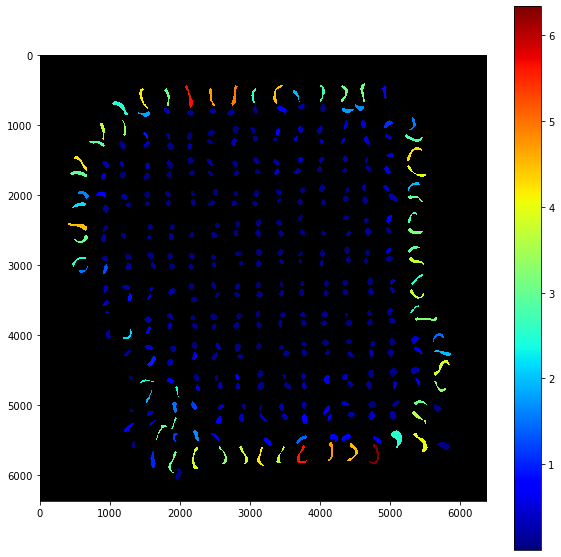

In [90]:
im_color=np.zeros( (img.shape[0],img.shape[1]) )
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=dipole_list[ii]
plt.figure(figsize=(10,10))
im_color[im_color==0]=np.nan
cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap)

plt.colorbar(im)




<ipython-input-89-5c45a8e04ae0>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


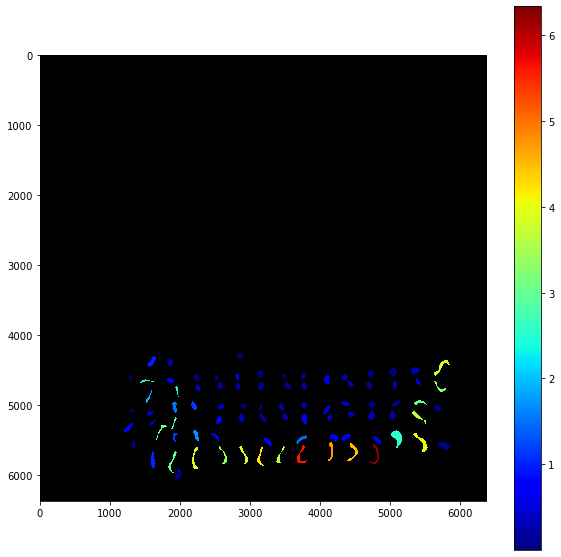

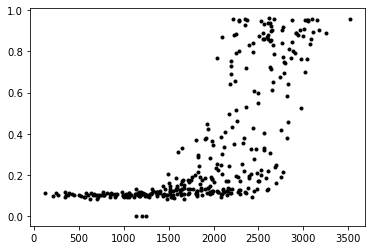

In [135]:
repe=np.repeat([[3186, 3186]],np.shape(centroid_list)[0],axis=0)
dist=np.sqrt((repe[:,0]-centroid_list[:,0])**2+(repe[:,1]-centroid_list[:,1])**2)
plt.plot(dist,dipole_list,'k.')

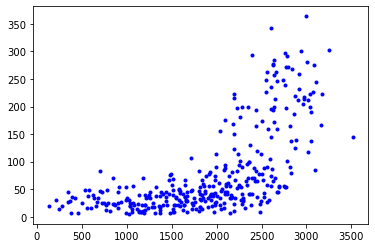

In [133]:
plt.plot(dist,elongation_list,'b.')

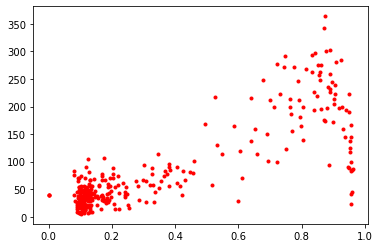

In [134]:
plt.plot(dipole_list,elongation_list,'r.')

(282.25, 6018.75, 267.75, 6257.25)

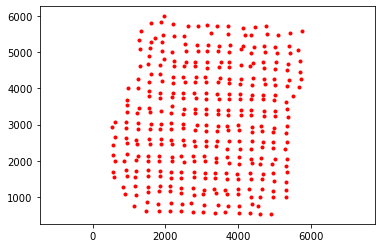

In [138]:
plt.plot(centroid_list[:,1],centroid_list[:,0],'r.')
plt.axis('equal')